### Medmentions

In [1]:
semgroups = "/kaggle/input/thesis/SemGroups_2018.txt"
semtypes = "/kaggle/input/thesis/SemanticTypes_2018AB.txt"
medmentions = "/kaggle/input/thesis/corpus_pubtator.txt"
umls_concept = "/kaggle/input/thesis/MRCONSO.RRF"

#### Helper functions

In [2]:
from itertools import islice

def read_in_chunks(file_object, n=10000):
    """Lazy function (generator) to read a file piece by piece.
    Default chunk size: 1k."""
    while True:
        data = list(islice(file_object, n))
        if not data:
            break
        yield data

        
def umls_concepts():
    umls_concepts = {}
    with open(umls_concept) as f:
        for piece in read_in_chunks(f):
            for line in piece:
                if line != "":
                    line_list = line.split("|")
                    if line_list[1] == 'ENG':
                        umls_concepts[line_list[0]] = line_list[14]
    return umls_concepts


def umls_semtype():
    umls_semtype = {}
    with open(semgroups) as f:
        f = f.read().split("\n")
        for line in f:
            if line != "":
                line_list = line.split("|")
                umls_semtype[line_list[2]] = [line_list[1], line_list[3]]
    return umls_semtype

In [3]:
umls_concepts = umls_concepts()
umls_semtype = umls_semtype()

umls_semtype['T131']

['Chemicals & Drugs', 'Hazardous or Poisonous Substance']

### Make the data

In [4]:
#medmentions
import numpy as np

def form_medmentions_data():
  entity_data = {}
  full_text = {}
  paper_ids = []
  sequence = []
  sequence_entities = []
  with open(medmentions) as f:
    f = f.read().split("\n")
    for line in f:
      if "|" in line:
        full_text_list = line.split("|")
        if full_text_list[0] in full_text.keys():
          full_text[full_text_list[0]] += "." +  full_text_list[2] 
        else:
          full_text[full_text_list[0]] = full_text_list[2]
        if full_text_list[0] not in paper_ids:
            paper_ids.append(full_text_list[0]) 
            
      elif "|" not in line:
        line_list = line.split("\t")
        if line_list != ['']:        
          if ',' in line_list[4]:
            entities_list = line_list[4].split(",")
            #for now take the first one only
            entity =  umls_semtype[entities_list[0]][1]
          elif line_list[4] == "UnknownType":
            entity = "O"
          else:
            entity =  umls_semtype[line_list[4]][1]
          full_text[line_list[0]] = full_text[line_list[0]].replace(line_list[3], " XXXX ", 1)

        
          if line_list[0] in entity_data.keys(): 
            entity_data[line_list[0]].append([line_list[3], entity])
          else:
            entity_data[line_list[0]] = [[line_list[3], entity]]

    for id in paper_ids:
      annotated_entity = []
      text = full_text[id].split(" ")
      text = list(filter(None, text))
      entity_idx = -1
      for remaining_item in text:
        if remaining_item == "XXXX":
          entity_idx+=1
          annotated_entity.append(entity_data[id][entity_idx])
        else:
          annotated_entity.append([remaining_item,'O'])
      annotated_entity = np.transpose(np.array(annotated_entity))
      sequence.append(list(annotated_entity[0]))
      sequence_entities.append(list(annotated_entity[1]))
        
  del entity_data
  del full_text

  return sequence, sequence_entities

sequences, sequence_entities = form_medmentions_data()

### upsampling minority classes

In [5]:
def minority_classes(entities):
    class_count = {}
    for seq_tags in entities:
        for tag in seq_tags:
            if tag not in class_count.keys():
                class_count[tag] = 1
            else:
                class_count[tag] += 1
    
    threeshold = 20

    less_represented_classes = {}
    
    for k, v in class_count.items():
        if v < threeshold:
            less_represented_classes[k] = v

    return less_represented_classes

minority_classes(sequence_entities)            

{'Self-help or Relief Organization': 19,
 'Fully Formed Anatomical Structure': 2,
 'Drug Delivery Device': 19,
 'Vitamin': 2}

In [6]:
def upsample(sequence, entity):
    added_sequences = []
    added_entities = []
    for x, y in zip(sequence, entity):
        for k, v in minority_classes(entity).items():
            if k in y:
                for _ in range(10):
                    added_sequences.append(x)
                    added_entities.append(y)
    
    sequence.extend(added_sequences)
    entity.extend(added_entities)
    return sequence, entity

### encoding

In [8]:
def tokens_tags(data_X, data_y):
    vocab = []
    tags = []
    for seq in data_X:
        for word in np.unique(seq):
            if word.lower() not in vocab:
                vocab.append(word.lower())
    for seq_ent in data_y:
        for ent in seq_ent:
            if ent not in tags:
                tags.append(ent)
                
    return len(vocab), len(tags), max([len(s) for s in sequences])

num_tokens, num_tags, maxlen = tokens_tags(sequences, sequence_entities)
print('Number of unique tokens ', num_tokens)
print('Max length of sequence ', maxlen)
print('Number of unique tags ', num_tags)

Number of unique tokens  106375
Max length of sequence  685
Number of unique tags  126


In [39]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.preprocessing import text, sequence

def encode_pad_data():
    tokenizer = text.Tokenizer(num_words=num_tokens, lower=True)
    label_tokenizer = text.Tokenizer(num_tags, lower=True)
    tokenizer.fit_on_texts(sequences)
    label_tokenizer.fit_on_texts(sequence_entities)
    
    encoded_sequences = tokenizer.texts_to_sequences(sequences)
    encoded_entities = label_tokenizer.texts_to_sequences(sequence_entities)    
    
    encoded_sequences, encoded_entities = upsample(encoded_sequences, encoded_entities)
    encoded_entities_ohe = [to_categorical(i, num_classes=num_tags) for i in encoded_entities]
    
    pad_seqs = sequence.pad_sequences(encoded_sequences, dtype='int32', maxlen=maxlen, padding='post')
    pad_tags = sequence.pad_sequences(encoded_entities_ohe, maxlen=maxlen, dtype='int32', padding='post')
    
    return maxlen, num_tags, pad_tags, pad_seqs, tokenizer ,label_tokenizer

maxlen, num_tags, pad_tags, pad_seqs, tokenizer ,label_tokenizer = encode_pad_data()

### Eval Metrics

In [10]:
import tensorflow as tf
from keras import backend as K
from sklearn.metrics import fbeta_score


def mask(m, q):
    # Assumes m is 2D
    mask = tf.math.reduce_any(tf.not_equal(m, q), axis=-1)
    #return tf.boolean_mask(m, mask)
    return mask


def recall(y_true, y_pred):
    pad = tf.constant([0 for i in range(num_tags)], dtype=tf.float32)
    mask_ = mask(y_true, pad)
    masked_y_data = tf.boolean_mask(y_true, mask_)
    masked_y_pred = tf.boolean_mask(y_pred, mask_)
    true_positives = K.sum(K.round(K.clip(masked_y_data * masked_y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(masked_y_data, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    pad = tf.constant([0 for i in range(num_tags)], dtype=tf.float32)
    mask_ = mask(y_true, pad)
    masked_y_data = tf.boolean_mask(y_true, mask_)
    masked_y_pred = tf.boolean_mask(y_pred, mask_)
    true_positives = K.sum(K.round(K.clip(masked_y_data * masked_y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(masked_y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+K.epsilon()))


def exclude_from_f1(y_true, y_pred, excluded_tags=[0]):
    ytrue, yhat = [], []
    for y_t, y_p in zip(y_true, y_pred):
        if y_t not in excluded_tags:
            ytrue.append(y_t)
            yhat.append(y_p)
    f1 = f1_score(ytrue, yhat, average='weighted')
    return f1


def matthews_correlation(y_true, y_pred):
    pad = tf.constant([0 for i in range(num_tags)], dtype=tf.float32)
    mask_ = mask(y_true, pad)
    y_true = tf.boolean_mask(y_true, mask_)
    y_pred = tf.boolean_mask(y_pred, mask_)
    
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_f1')>=0.8):
            print('accuracy reached')
            self.model.stop_training = True
accuracy_reached = myCallback()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


class SGDRScheduler(tf.keras.callbacks.Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.

    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        self.steps_per_epoch = self.params['steps'] if self.params['steps'] is not None else round(self.params['samples'] / self.params['batch_size'])
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

### class weights

In [40]:
import collections
#Class weights
def class_weights():
    
    total = np.array(pad_tags).shape[0]*np.array(pad_tags).shape[1]
            
    class_dict = {}
    
    for seq_tags in np.array(pad_tags):
        for tag_ohe in seq_tags:
            if 1 in tag_ohe:
                tag = np.where(tag_ohe == 1)[0][0]
            else:
                tag = 0
            
            if tag not in class_dict.keys():
                class_dict[tag] = 1
            else:
                class_dict[tag] += 1
    
    class_weight = {}

    for key, value in class_dict.items():
        class_weight[key] = (1 / value * total / num_tags)**(1/2)
    
    class_weight = collections.OrderedDict(sorted(class_weight.items()))
    class_weight[0] = 0
    return class_weight

class_weights_dict = class_weights()

## Stratifying Train Test Validation Split

In [41]:
from sklearn.model_selection import train_test_split

def train_test_data():

    X = np.array(pad_seqs)
    y = np.array(pad_tags)
    
    data = train_test_split(X, y, test_size=0.1, random_state=42)
    test_X, test_y =  data[1], data[3]
    train_X, val_X, train_y, val_y = train_test_split(data[0], data[2], test_size=0.05, random_state=42)
    
    class_to_add = []
    for i in np.unique(np.argmax(train_y, axis=-1)):
        if i not in np.unique(np.argmax(val_y, axis=-1)):
            class_to_add.append(i)
        
    for class_ in class_to_add:
        idx = 0            
        for y in train_y:
            if class_ not in np.argmax(y, axis=-1):
                idx += 1
            else:
                break        
        val_y = np.append(val_y, train_y[idx]) 
        val_X = np.append(val_X, train_X[idx])  
        val_y = val_y.reshape((int(val_y.shape[0]/(num_tags*maxlen)), maxlen, num_tags))
        val_X = val_X.reshape((int(val_X.shape[0]/maxlen), maxlen))
        train_y = np.delete(train_y, idx, 0)
        train_X = np.delete(train_X, idx, 0)
    
    class_to_add = []
    for i in np.unique(np.argmax(train_y, axis=-1)):
        if i not in np.unique(np.argmax(test_y, axis=-1)):
            class_to_add.append(i)
    
    for class_ in class_to_add:
        idx = 0            
        for y in train_y:
            if class_ not in np.argmax(y, axis=-1):
                idx += 1
            else:
                break
        test_y = np.append(test_y, train_y[idx]) 
        test_X = np.append(test_X, train_X[idx])  
        test_y = test_y.reshape((int(test_y.shape[0]/(num_tags*maxlen)), maxlen, num_tags))
        test_X = test_X.reshape((int(test_X.shape[0]/maxlen), maxlen))
        train_y = np.delete(train_y, idx, 0)
        train_X = np.delete(train_X, idx, 0)
    
    return train_X, val_X, train_y, val_y, test_X, test_y

train_X, val_X, train_y, val_y, test_X, test_y = train_test_data()

In [42]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape

((3875, 685),
 (3875, 685, 126),
 (456, 685),
 (456, 685, 126),
 (211, 685),
 (211, 685, 126))

In [43]:
np.unique(np.argmax(train_y, axis=-1)).shape, np.unique(np.argmax(test_y, axis=-1)).shape, np.unique(np.argmax(val_y, axis=-1)).shape

((126,), (126,), (126,))

### Class Weight Matrix

In [44]:
def create_weight_arr(y_data, weight_dict):
    class_weights_arr = np.empty((y_data.shape[0], y_data.shape[1]))

    for x in np.arange(class_weights_arr.shape[0]):
        for y in np.arange(class_weights_arr.shape[1]):
            if 1 in y_data[x, y]:
                tag = np.where(y_data[x, y] == 1)[0][0]
            else:
                tag = 0
            class_weights_arr[x, y] = weight_dict[tag]
    return class_weights_arr

class_weights_arr = create_weight_arr(train_y, class_weights_dict)

### BiLSTM Model

In [45]:
#Now train the model
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Layer
from tensorflow.keras.utils import plot_model
from keras.optimizers import SGD, Adam, RMSprop

opt = Adam(0.1)
output_dim = 16
tf.random.set_seed(42)

sequence_input = Input(shape=(maxlen,), dtype=tf.int32, name='sequence_input')
sequence_mask = Lambda(lambda x: tf.greater(x, 0))(sequence_input)
outputs = Embedding(input_dim=np.max(pad_seqs)+1, output_dim=output_dim, trainable=True, mask_zero=True)(sequence_input)
outputs = Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.3, recurrent_dropout=0.3), merge_mode = 'concat')(outputs)
outputs = (TimeDistributed(Dense(num_tags, activation="softmax")))(outputs)

model = Model(inputs=sequence_input, outputs=outputs)
model.compile(loss='CategoricalCrossentropy', optimizer=opt, metrics=[f1, precision, recall,matthews_correlation])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence_input (InputLayer)  [(None, 685)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 685, 16)           1702000   
_________________________________________________________________
bidirectional (Bidirectional (None, 685, 32)           4224      
_________________________________________________________________
time_distributed (TimeDistri (None, 685, 126)          4158      
Total params: 1,710,382
Trainable params: 1,710,382
Non-trainable params: 0
_________________________________________________________________


In [46]:
his = model.fit(train_X, train_y, epochs=40, batch_size=256, validation_data=(val_X, val_y),
                sample_weight=class_weights_arr, callbacks=[accuracy_reached])

Epoch 1/40
16/16 [==============================] - 34s 2s/step - loss: 1.3419 - f1: 0.2080 - precision: 0.3509 - recall: 0.1532 - matthews_correlation: 0.2272 - val_loss: 0.5705 - val_f1: 0.6659 - val_precision: 0.9709 - val_recall: 0.5067 - val_matthews_correlation: 0.6999
Epoch 2/40
16/16 [==============================] - 28s 2s/step - loss: 1.0036 - f1: 0.6755 - precision: 0.9741 - recall: 0.5174 - matthews_correlation: 0.7082 - val_loss: 0.4390 - val_f1: 0.7394 - val_precision: 0.9093 - val_recall: 0.6230 - val_matthews_correlation: 0.7511
Epoch 3/40
16/16 [==============================] - 26s 2s/step - loss: 0.6321 - f1: 0.7445 - precision: 0.9119 - recall: 0.6294 - matthews_correlation: 0.7559 - val_loss: 0.4161 - val_f1: 0.7710 - val_precision: 0.8765 - val_recall: 0.6881 - val_matthews_correlation: 0.7751
Epoch 4/40
16/16 [==============================] - 26s 2s/step - loss: 0.4356 - f1: 0.7993 - precision: 0.8935 - recall: 0.7233 - matthews_correlation: 0.8025 - val_loss: 

### Visulize Model Results

<Figure size 432x288 with 0 Axes>

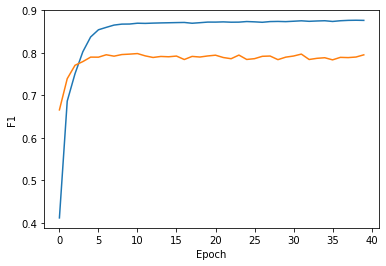

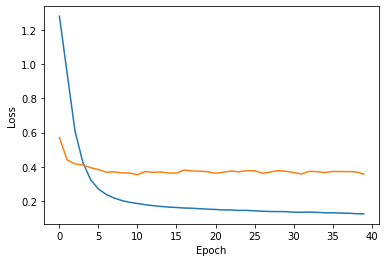

<Figure size 432x288 with 0 Axes>

In [47]:
matthews = his.history['matthews_correlation']
loss = his.history['loss']
f1 = his.history['f1']
val_matthews = his.history['val_matthews_correlation']
val_loss = his.history['val_loss']
val_f1 = his.history['val_f1']

epochs = range(len(f1))

import matplotlib.pyplot as plt

plt.plot(epochs, f1)
plt.plot(epochs, val_f1)
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.figure()


plt.plot(epochs,loss)
plt.plot(epochs, val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure()

In [48]:
model.evaluate(test_X, test_y)

15/15 [==============================] - 2s 109ms/step - loss: 0.3446 - f1: 0.8011 - precision: 0.8586 - recall: 0.7509 - matthews_correlation: 0.8015


[0.3446122407913208,
 0.8011369705200195,
 0.858588457107544,
 0.7509198188781738,
 0.8014841079711914]

In [50]:
from sklearn.metrics import f1_score
f1_scores_no_O, f1_scores_with_O = [], []
for x, y in zip(test_X, test_y):
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = np.argmax(y, axis=-1)
    f1_scores_no_O.append(exclude_from_f1(y_true, y_pred, excluded_tags=[0, 1]))
    f1_scores_with_O.append(exclude_from_f1(y_true, y_pred, excluded_tags=[0]))

print('f1 score on test data including "Other" tag', np.mean(f1_scores_with_O))
print('f1 score on test data without "Other" tag', np.mean(f1_scores_no_O))

f1 score on test data including "Other" tag 0.7669305006679763
f1 score on test data without "Other" tag 0.6443708256484537


### Confusion matrix of test data

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

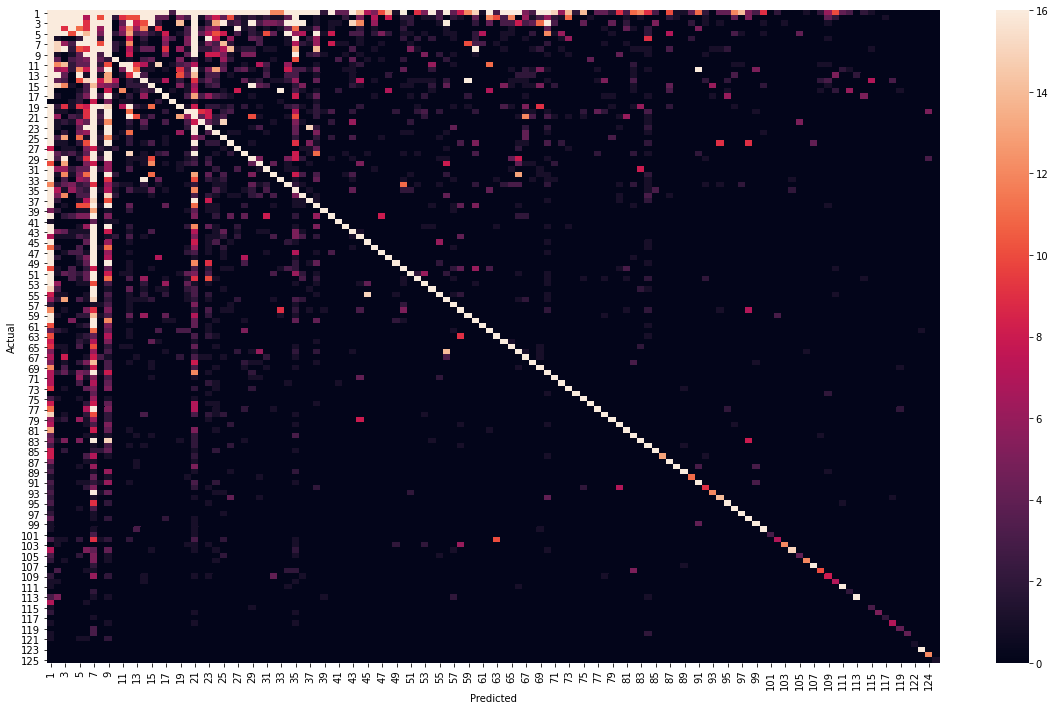

In [51]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

testpred = model.predict(test_X)

ypred = np.argmax(testpred, axis=-1).flatten()
y = np.argmax(test_y, axis=-1).flatten()

ytrue, yhat = [], []
for y_t, y_p in zip(y, ypred):
    if y_t != 0:
        ytrue.append(y_t)
        yhat.append(y_p)

import pandas as pd
y_actu = pd.Series(ytrue, name='Actual')
y_pred = pd.Series(yhat, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

plt.figure(figsize = (20,12))
sns.heatmap(df_confusion, robust=True)

### Confusion matrix for last article

Confusion matrix looks alittle weird because some predicted entites contains more than the actual entities in this sample article seqeunce

In [54]:
np.unique(y), np.unique(ypred)

(array([  0,   1,   2,   3,   4,   5,   7,   8,   9,  10,  12,  13,  19,
         40,  41,  47,  70, 114]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 17, 19, 21,
        26, 34, 35, 37, 38, 40, 41, 47, 60, 96]))

In [52]:
inv_map = {v: k for k, v in label_tokenizer.word_index.items()}

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

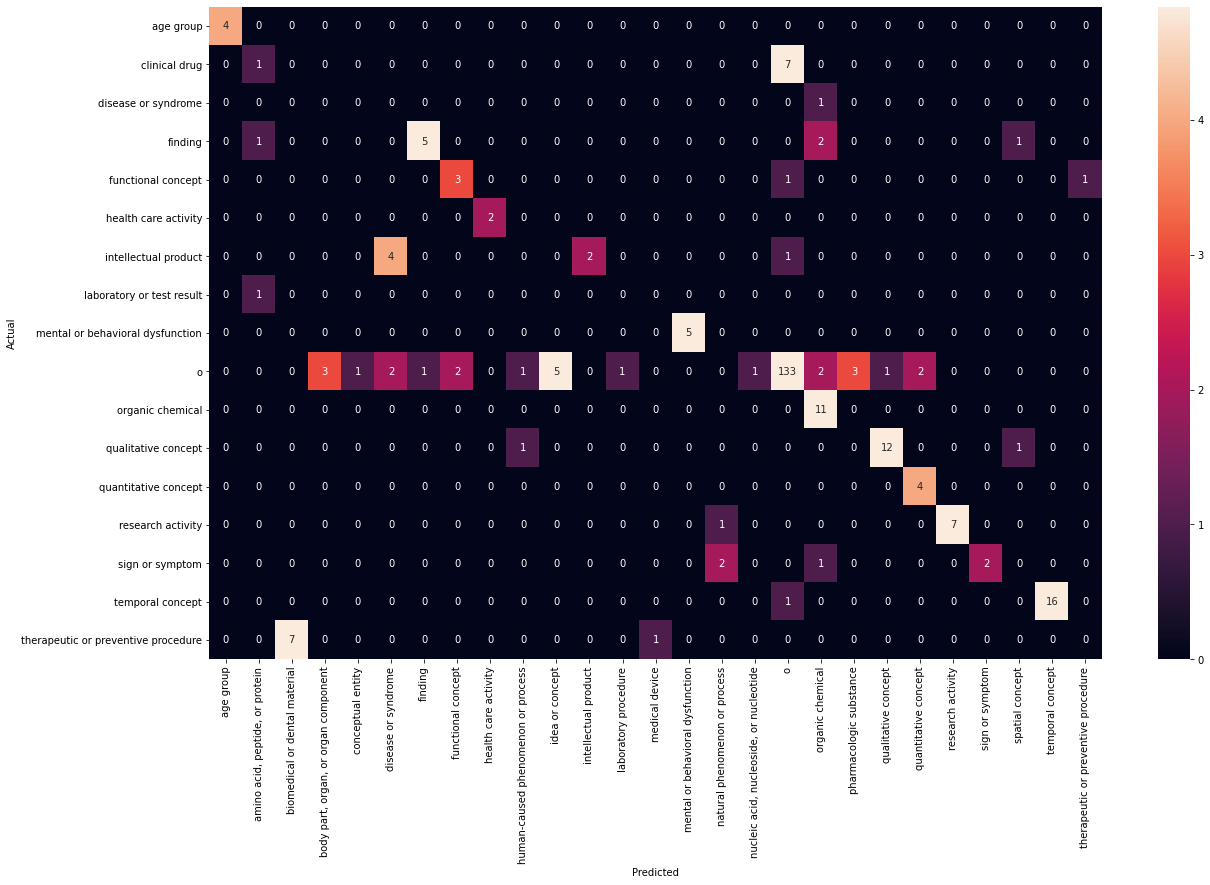

In [53]:
ypred = np.argmax(testpred[-1], axis=-1)
y = np.argmax(test_y[-1], axis=-1)

ytrue, yhat = [], []
for y_t, y_p in zip(y, ypred):
    if y_t != 0:
        ytrue.append(inv_map[y_t])
        yhat.append(inv_map[y_p])

import pandas as pd
y_actu = pd.Series(ytrue, name='Actual')
y_pred = pd.Series(yhat, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
plt.figure(figsize = (20,12))
sns.heatmap(df_confusion, annot=True, robust=True, fmt='g')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# BiLSTM CNN

In [66]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, Dense, LSTM, TimeDistributed, Lambda,Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from tensorflow.keras.models import Model
from keras.optimizers import SGD, Adam, RMSprop

output_dim = 16
tf.random.set_seed(42)
opt = Adam(0.005)

sequence_input = Input(shape=(maxlen,), dtype=tf.int32, name='sequence_input')
sequence_mask = Lambda(lambda x: tf.greater(x, 0))(sequence_input)
outputs = Embedding(input_dim=num_tokens+1, output_dim=output_dim, trainable=True, mask_zero=True)(sequence_input)
#outputs = SpatialDropout1D(0.35)(outputs)
outputs = Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat')(outputs)
#outputs = (TimeDistributed(Dense(output_dim, activation="relu")))(outputs)
outputs = Conv1D(64, kernel_size=3, padding='same', kernel_initializer='glorot_uniform')(outputs)

avg_pool = GlobalAveragePooling1D()(outputs)
max_pool = GlobalAveragePooling1D()(outputs)
outputs = concatenate([avg_pool, max_pool])

outputs = Dense(num_tags, activation="softmax")(outputs)

model = Model(inputs=sequence_input, outputs=outputs)
model.compile(loss = 'CategoricalCrossentropy', optimizer=opt)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     [(None, 685)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 685, 16)      1702016     sequence_input[0][0]             
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 685, 32)      4224        embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 685, 64)      6208        bidirectional_2[0][0]            
____________________________________________________________________________________________

In [60]:
def get_weights(y_classes):   
    y_classes = np.argmax(y_classes, axis=-1)
    total = len(y_classes)
    class_dict = {}
    for tag in y_classes:
        if tag not in class_dict.keys():
            class_dict[tag] = 1
        else:
            class_dict[tag] += 1

    class_weight = {}

    for key, value in class_dict.items():
        class_weight[key] = (1 / value * total / num_tags)
    
    for i in range(127):
        if i not in class_weight.keys():
            class_weight[i] = 0
    class_weight[0] = 0
    return class_weight

In [67]:
from sklearn.metrics import f1_score

train_f1 = []
train_loss = []
val_f1 = []
val_loss = []

for epoch in range(1, 11):
    
    print('Epoch', epoch)
    
    for x, y in zip(train_X, train_y):
        weights = get_weights(y)
        model.train_on_batch(x, y, class_weight=weights)
        #train_his = model.evaluate(x, y, verbose=0)
        #y_pred = np.argmax(model.predict(x), axis=-1)    
        #f1.append(f1_score(y, y_pred, average='weighted'))    
        #loss.append(train_his[0])    
    
    #train_f1.append(np.mean(f1))
    #train_loss.append(np.mean(loss))
    
    loss, f1 = [], []
    
    for x, y in zip(val_X, val_y):
        val_his = model.evaluate(x, y, verbose=0)
        y_pred = np.argmax(model.predict(x), axis=-1)
        y_true = np.argmax(y, axis=-1)
        f1.append(exclude_from_f1(y_true, y_pred, [0]))
        loss.append(val_his)
        
    val_f1.append(np.mean(f1))
    val_loss.append(np.mean(loss))
    print(val_f1, val_loss)

Epoch 1
[0.7536514001173813] [0.44499520226536204]
Epoch 2
[0.7536514001173813, 0.7690653692549279] [0.44499520226536204, 0.4400356885804949]
Epoch 3
[0.7536514001173813, 0.7690653692549279, 0.7707410478809176] [0.44499520226536204, 0.4400356885804949, 0.44245375869398434]
Epoch 4
[0.7536514001173813, 0.7690653692549279, 0.7707410478809176, 0.7686797520505156] [0.44499520226536204, 0.4400356885804949, 0.44245375869398434, 0.42595153188959683]
Epoch 5
[0.7536514001173813, 0.7690653692549279, 0.7707410478809176, 0.7686797520505156, 0.7715965689599222] [0.44499520226536204, 0.4400356885804949, 0.44245375869398434, 0.42595153188959683, 0.42289076307656076]
Epoch 6
[0.7536514001173813, 0.7690653692549279, 0.7707410478809176, 0.7686797520505156, 0.7715965689599222, 0.7695934980238991] [0.44499520226536204, 0.4400356885804949, 0.44245375869398434, 0.42595153188959683, 0.42289076307656076, 0.4331236027569567]
Epoch 7
[0.7536514001173813, 0.7690653692549279, 0.7707410478809176, 0.76867975205051

<Figure size 432x288 with 0 Axes>

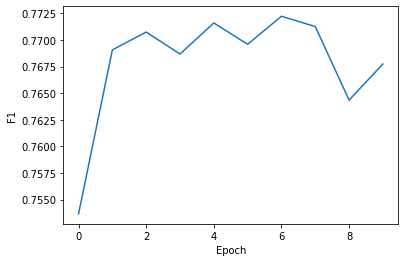

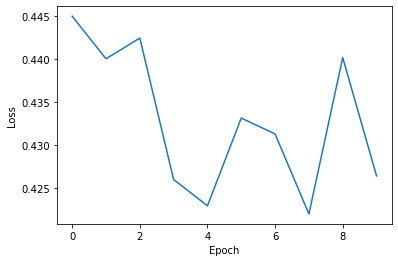

<Figure size 432x288 with 0 Axes>

In [68]:
plt.plot(range(len(val_f1)), val_f1)
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.figure()
plt.plot(range(len(val_loss)), val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure()

In [79]:
f1_scores_no_O, f1_scores_with_O = [], []
y_pred = []

for x, y in zip(test_X, test_y):
    ypred = model.predict(x)
    ypred = np.argmax(ypred, axis=-1)
    ytrue = np.argmax(y, axis=-1)
    y_pred.extend(ypred)
    f1_scores_no_O.append(exclude_from_f1(ytrue, ypred, [0, 1]))
    f1_scores_with_O.append(exclude_from_f1(ytrue, ypred, [0]))

print('f1 score on test data including "Other" tag', np.mean(f1_scores_with_O))
print('f1 score on test data without "Other" tag', np.mean(f1_scores_no_O))

f1 score on test data including "Other" tag 0.7755665050805709
f1 score on test data without "Other" tag 0.6486340567758293


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

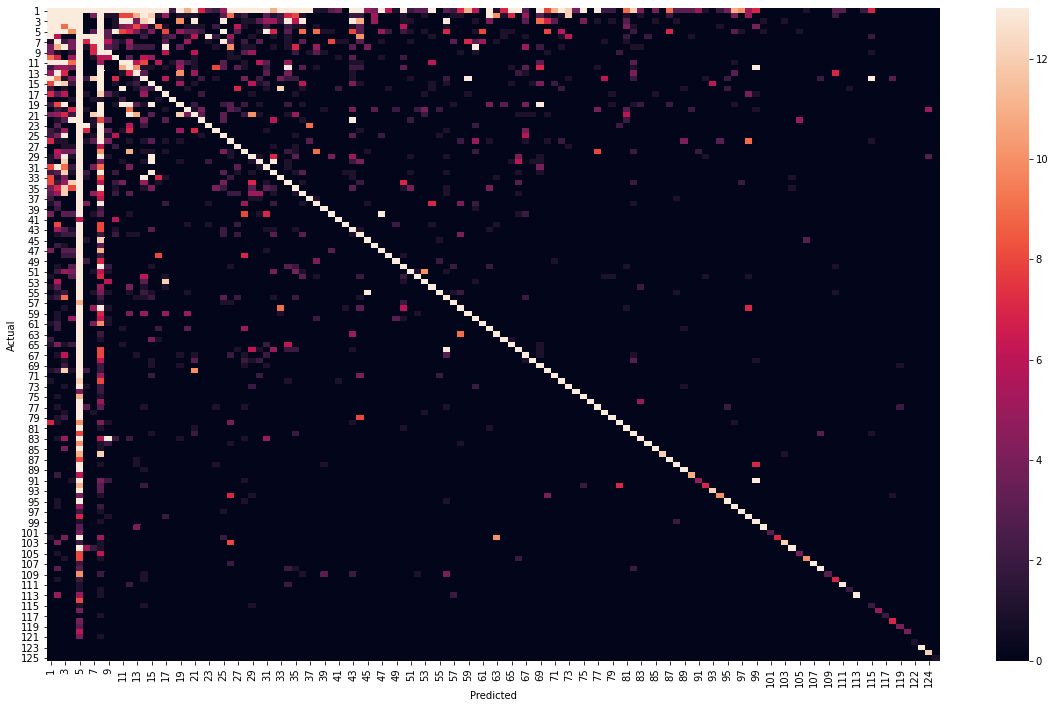

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

y_true = np.argmax(test_y, axis=-1).flatten()
y_pred = np.array(y_pred).flatten()

ytrue, yhat = [], []
for y_t, y_p in zip(y_true, y_pred):
    if y_t != 0:
        ytrue.append(y_t)
        yhat.append(y_p)
        
import pandas as pd
y_actual = pd.Series(ytrue, name='Actual')
y_pred = pd.Series(yhat, name='Predicted')
df_confusion = pd.crosstab(y_actual, y_pred)
        
plt.figure(figsize = (20,12))
sns.heatmap(df_confusion, robust=True)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

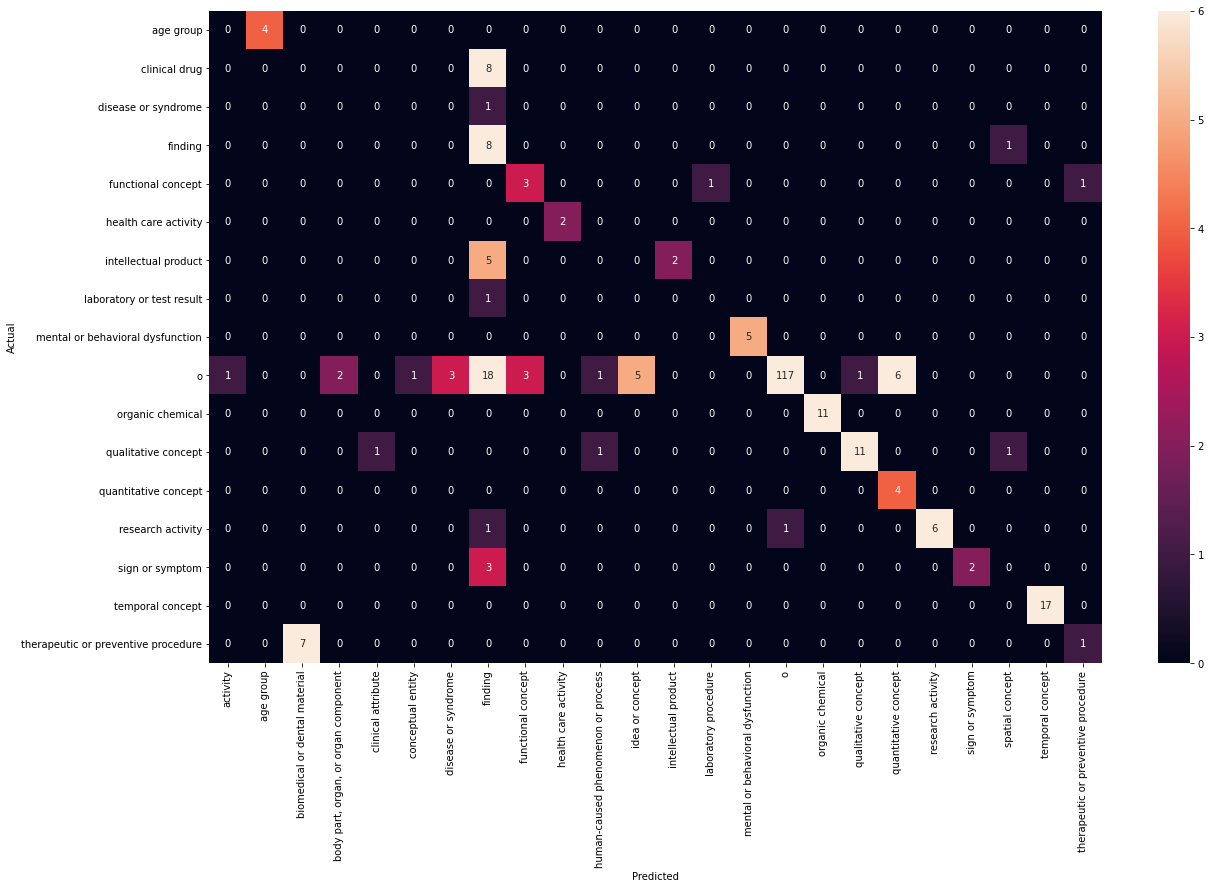

In [77]:
y_true =np.argmax(test_y[-1], axis=-1)
y_pred = np.argmax(model.predict(test_X[-1]), axis=-1)

ytrue, yhat = [], []
for y_t, y_p in zip(y_true, y_pred):
    if y_t != 0:
        ytrue.append(inv_map[y_t])
        yhat.append(inv_map[y_p])

import pandas as pd
y_actu = pd.Series(ytrue, name='Actual')
y_pred = pd.Series(yhat, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (20,12))
sns.heatmap(df_confusion, annot=True,robust=True, fmt='g')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# BiLSTM with CRF

In [ ]:
#!pip install keras_crf

from keras_crf import CRF
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, LSTM, TimeDistributed, Lambda
from tensorflow.keras.models import Model
from keras.optimizers import SGD, Adam, RMSprop

output_dim = 16
tf.random.set_seed(42)

sequence_input = Input(shape=(maxlen,), dtype=tf.int32, name='sequence_input')
sequence_mask = Lambda(lambda x: tf.greater(x, 0))(sequence_input)
outputs = Embedding(input_dim=num_tokens, output_dim=output_dim, trainable=True, mask_zero=True)(sequence_input)
#outputs = SpatialDropout1D(0.35)(outputs)
outputs = Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(outputs)
#outputs = Conv1D(64, kernel_size=3, padding='same', kernel_initializer='glorot_uniform')(outputs)

#avg_pool = GlobalAveragePooling1D()(outputs)
#max_pool = GlobalMaxPooling1D()(outputs)
#outputs = concatenate([avg_pool, max_pool])
outputs = Dense(num_tags, activation="relu")(outputs)

crf = CRF(num_tags)

# mask is important to compute sequence length in CRF
outputs = crf(outputs, mask=sequence_mask)


model = Model(inputs=sequence_input, outputs=outputs)
model.compile(
    loss =  crf.neg_log_likelihood,
    metrics = [crf.accuracy],
    optimizer = Adam(0.001))
model.summary()

In [ ]:
train_f1 = []
train_loss = []
val_f1 = []
val_loss = []

for epoch in range(1, 11):
    print('Epoch', epoch)
    
    for x, y in zip(train_X, train_y):
        model.train_on_batch(x, y, class_weight=class_weights_dict)
    
    loss, f1 = [], []
    
    for x, y in zip(val_X, val_y):
        val_his = model.evaluate(x, y, verbose=0)
        y_pred = np.argmax(model.predict(x), axis=-1)  
        f1.append(f1_score(y, y_pred, average='weighted'))
        loss.append(val_his[0])
        
    val_f1.append(np.mean(f1))
    val_loss.append(np.mean(loss))
    print(val_f1)